# Question 5: Changes year to year

This notebook aims to answer the fifth question of the project.

Year to year:

- Has there been an overall increase or reduction in crime?

- Has a certain type of offence seen a significant decrease or increase?

## Initial setup

In [1]:
# Dependencies
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
# silence correlation constant input warning
warnings.simplefilter('ignore', st.ConstantInputWarning)
# change plot style
plt.style.use('bmh')

In [2]:
# Define function to get correlation from two columns of a dataframe
def corr_from_df(col_name1, col_name2, df):
    try:
        a = df[col_name1].astype(float)
        b = df[col_name2].astype(float)

        correlation = st.pearsonr(a, b)
        return correlation
    # exception handling: if there is only one value
    except ValueError:
        return [float('nan'), float('nan')]

# Define function to print correlation from two columns of a dataframe
def print_corr_from_df(col_name1, col_name2, df):
    correlation = corr_from_df(col_name1, col_name2, df)
    # because we are rounding the p value to 3 decimal places,
    # if it is less than 0.001, print that instead of the actual value
    if correlation[1] < 0.001:
        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p < 0.001)\n")
    else:
        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p = {correlation[1]:.3f})\n")

In [3]:
# Read in data
df = pd.read_csv(Path('..', 'resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'LOCATION_TYPE': 'Location Type',
            'PREMISES_TYPE': 'Premises Type',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string and drop the .0 at the end
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)
# Check dataframe
df.head()

,Year,Location Type,Premises Type,Offence,Category
0,2014,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter
1,2014,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault
2,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Over,Theft Over
3,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault
4,2014,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault


## Total annual counts

We calculate the total number of crime events that happened each year, as well as the percentage change year on year. Then, we calculate the correlation between year and number of events, and plot both number of events and percentage change.

In [4]:
# general counts by year
year_df = (df
    .groupby('Year', as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)

year_df['Percentage Change'] = (year_df['Number of events'].pct_change()) * 100

year_df

,Year,Number of events,Percentage Change
0,2014,30202,NaN
1,2015,30641,1.453546
2,2016,31157,1.684018
3,2017,32790,5.241198
4,2018,34772,6.044526
5,2019,37114,6.735304
6,2020,32456,-12.550520
7,2021,32114,-1.053734
8,2022,37226,15.918291


The Pearson's correlation for Year and Number of events is:
        	0.68	(p = 0.043)



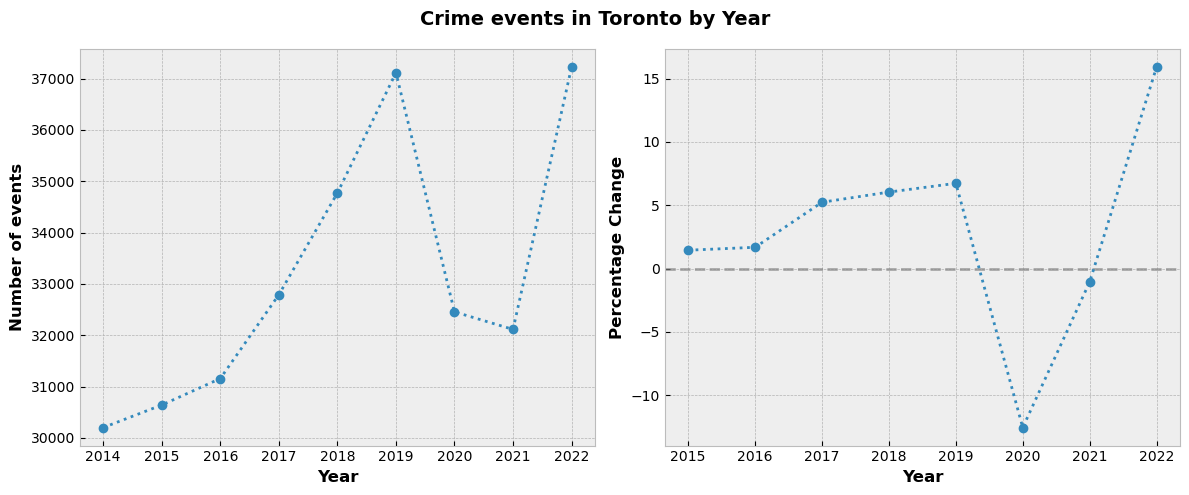

In [5]:
print_corr_from_df('Year', 'Number of events', year_df)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax2.axhline(color='grey', linestyle='--', alpha=0.65)


for ax in [ax1, ax2]:
    if ax is ax1:
        col = 'Number of events'
    else:
        col = 'Percentage Change'


    ax.plot(
        year_df['Year'],
        year_df[col],
        'o:',
        label = col
    )
    ax.set_xlabel('Year', fontdict={'weight': 700})
    ax.set_ylabel(col, fontdict={'weight': 700})

fig.suptitle(
    t='Crime events in Toronto by Year',
    fontweight=700, fontsize=14
)

plt.tight_layout()

plt.show()

## By category

In [6]:
# count by category and year
year_cat_df = (df
    .groupby(['Year', 'Category'], as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)

cats = list(year_cat_df['Category'].unique())

year_cat_df['Percentage Change'] = (year_cat_df['Number of events'].pct_change(periods=5)) * 100

year_cat_df.head(10)

,Year,Category,Number of events,Percentage Change
0,2014,Assault,15294,NaN
1,2014,Auto Theft,3485,NaN
2,2014,Break and Enter,7216,NaN
3,2014,Robbery,3193,NaN
4,2014,Theft Over,1014,NaN
5,2015,Assault,16547,8.192755
6,2015,Auto Theft,3090,-11.334290
7,2015,Break and Enter,6934,-3.907982
8,2015,Robbery,3028,-5.167554
9,2015,Theft Over,1042,2.761341


Category: Assault
The Pearson's correlation for Year and Number of events is:
        	0.62	(p = 0.077)

Category: Auto Theft
The Pearson's correlation for Year and Number of events is:
        	0.88	(p = 0.002)

Category: Break and Enter
The Pearson's correlation for Year and Number of events is:
        	-0.32	(p = 0.408)

Category: Robbery
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Category: Theft Over
The Pearson's correlation for Year and Number of events is:
        	0.67	(p = 0.048)



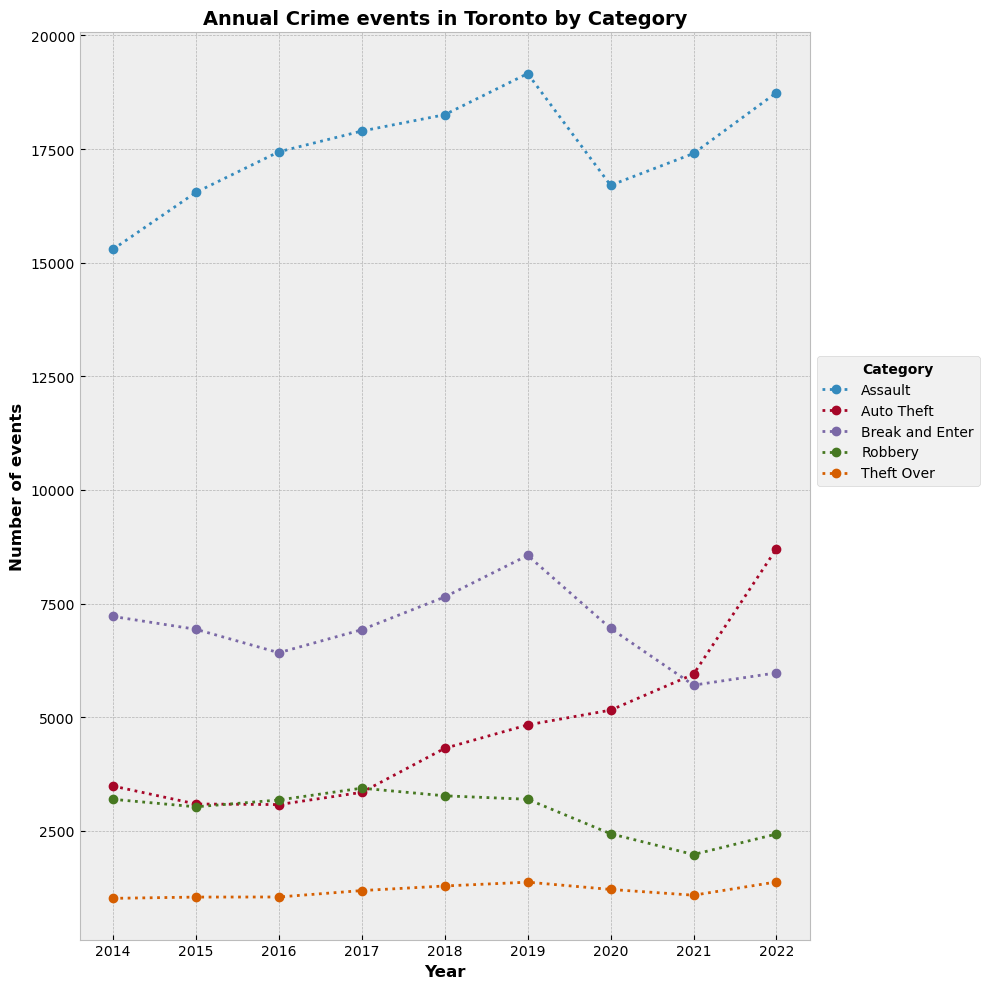

In [7]:
# Visualize
fig, ax = plt.subplots(figsize=(10,10))

ax2.axhline(color='grey', linestyle='--', alpha=0.65)

for cat in cats:
    this_data = year_cat_df.loc[year_cat_df['Category'] == cat]

    print(f"Category: {cat}")
    print_corr_from_df('Year', 'Number of events', this_data)

    # add this category to plot
    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        'o:',
        label=cat
    )


ax.set_xlabel('Year', fontdict={'weight': 700})
ax.set_ylabel('Number of events', fontdict={'weight': 700})
ax.set_title('Annual Crime events in Toronto by Category', fontdict={'weight': 700, 'size': 14})


ax.legend(
    loc=(1.01, 0.5),
    title='Category',
    title_fontproperties={'weight': 700}
)

plt.tight_layout()

plt.show()

## By premises type

In [8]:
year_premises_df = (df
    .groupby(['Year', 'Premises Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_premises_df

,Year,Premises Type,Number of events
0,2014,Apartment,7421
1,2014,Commercial,5452
2,2014,Educational,942
3,2014,House,6196
4,2014,Other,1554
...,...,...,...
58,2022,Educational,734
59,2022,House,6805
60,2022,Other,2398
61,2022,Outside,10273


Premises type: Apartment
The Pearson's correlation for Year and Number of events is:
        	0.52	(p = 0.155)

Premises type: Commercial
The Pearson's correlation for Year and Number of events is:
        	0.59	(p = 0.092)

Premises type: Educational
The Pearson's correlation for Year and Number of events is:
        	-0.62	(p = 0.075)



Premises type: House
The Pearson's correlation for Year and Number of events is:
        	0.09	(p = 0.818)

Premises type: Other
The Pearson's correlation for Year and Number of events is:
        	0.86	(p = 0.003)

Premises type: Outside
The Pearson's correlation for Year and Number of events is:
        	0.71	(p = 0.032)

Premises type: Transit
The Pearson's correlation for Year and Number of events is:
        	0.96	(p < 0.001)



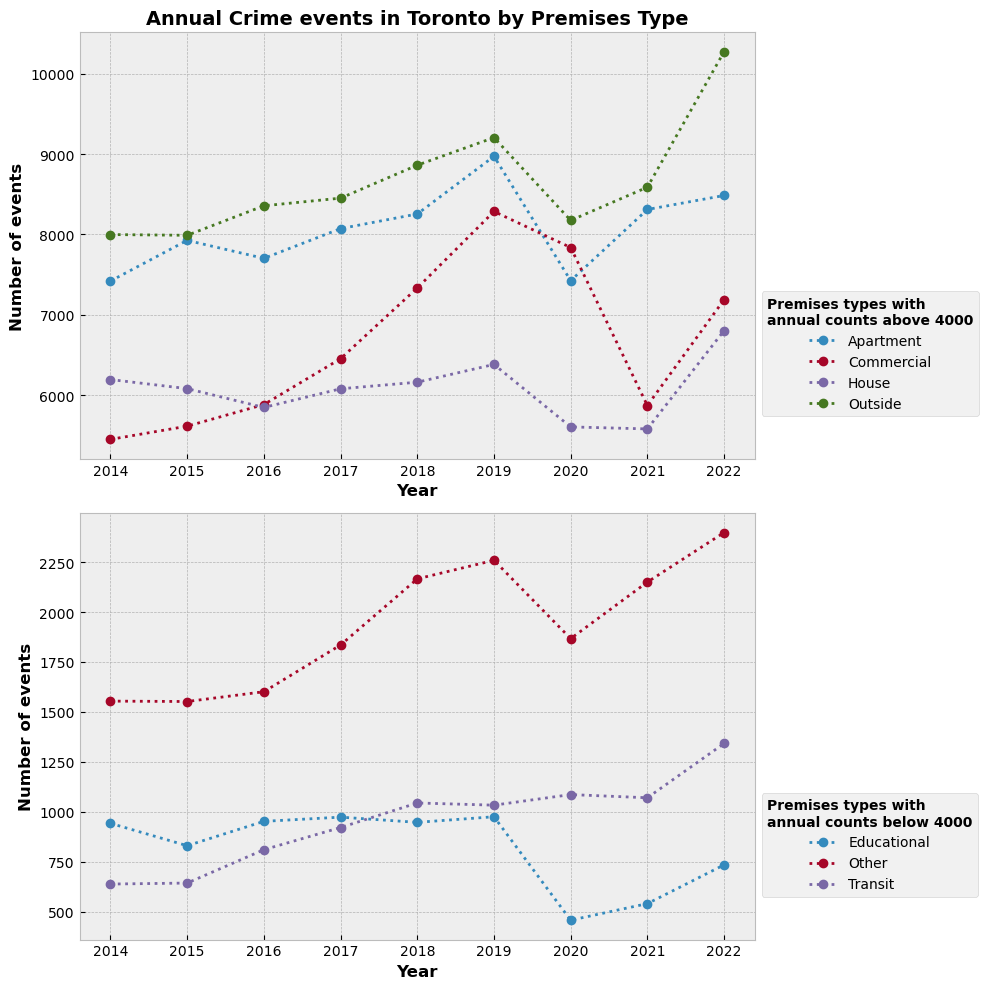

In [20]:
# Visualize

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))


mid_lim = 4000

# List of premises types
premises = list(year_premises_df['Premises Type'].unique())

for idx, prem in enumerate(premises):
    this_data = year_premises_df.loc[year_premises_df['Premises Type'] == prem]

    
    print(f"Premises type: {prem}")
    print_corr_from_df('Year', 'Number of events', this_data)



    if max(this_data['Number of events']) < mid_lim:
        ax = ax2
    else:
        ax = ax1

    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        'o:',
        label=prem
    )
for ax in [ax1, ax2]:
    if ax is ax1:
        direction = ' above '
    else:
        direction = ' below '

    ax.legend(
        loc=(1.01, 0.1),
        title='Premises types with\nannual counts' + direction + str(mid_lim),
        title_fontproperties={'weight': 700}
    )
    
    ax.set_ylabel(
        'Number of events' ,
        fontdict={'weight': 700}
    )
    
    
    ax.set_xlabel('Year', fontdict={'weight': 700})



ax1.set_title(
    'Annual Crime events in Toronto by Premises Type',
    fontdict={'weight': 700, 'size': 14}
)

plt.tight_layout()
# fig.subplots_adjust(hspace=0)

plt.show()



# Extras: subcategories and location types

## By subcategory

Most interesting: robbery subcategories

In [10]:
year_subcat_df = (df
    .groupby(['Year', 'Category', 'Offence'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_subcat_df.head()


,Year,Category,Offence,Number of events
0,2014,Assault,Administering Noxious Thing,29
1,2014,Assault,Aggravated Aslt Peace Officer,1
2,2014,Assault,Aggravated Assault,262
3,2014,Assault,Aggravated Assault Avails Pros,3
4,2014,Assault,Air Gun Or Pistol: Bodily Harm,1


### Break and Enter

Category: Break and Enter
Subcategory: B&E W'Intent
The Pearson's correlation for Year and Number of events is:
        	-0.66	(p = 0.052)



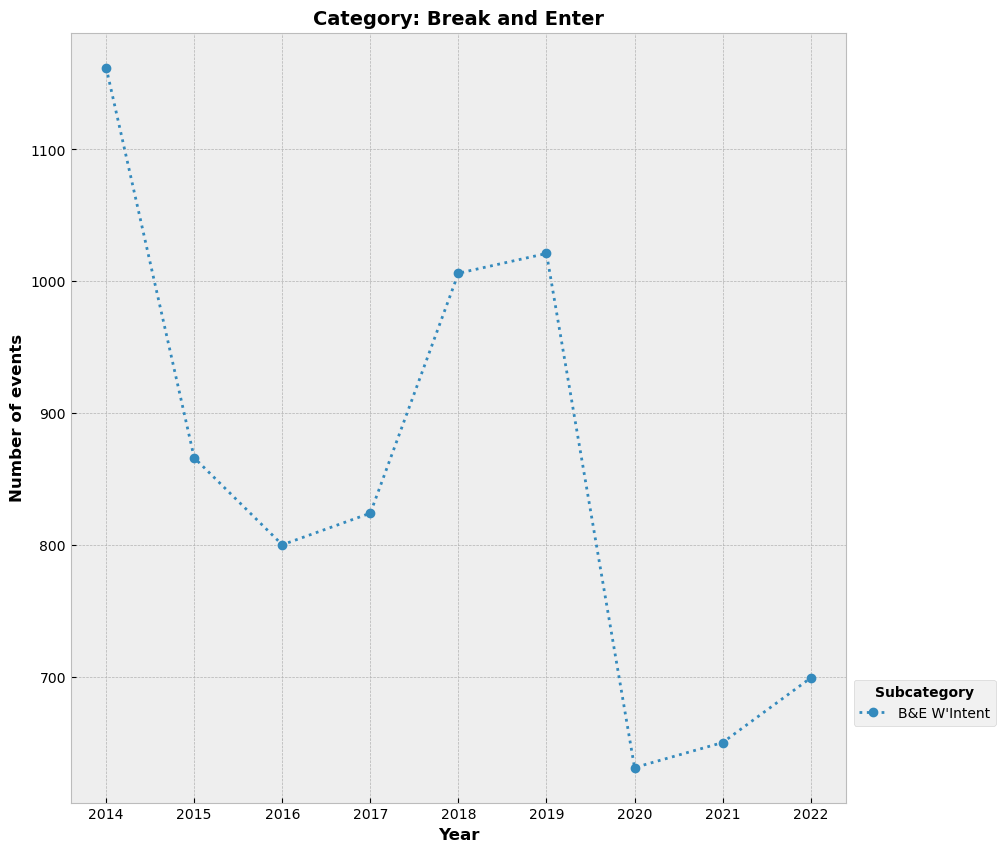

In [11]:
# Visualize
min_count = 0
# only show moderate and
limitcorr = 0.5

cat = cats[2]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat}")
offences = list(this_data['Offence'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for offence in offences:
    
    this_data_off = this_data.loc[this_data['Offence'] == offence]


    if any(this_data_off['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )
ax.legend(
    loc=(1.01, 0.1),
    title='Subcategory',
    title_fontproperties={'weight': 700}
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Category: ' + cat,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()



### Robbery

Category: Robbery
Subcategory: Robbery - Business
The Pearson's correlation for Year and Number of events is:
        	0.79	(p = 0.011)

Subcategory: Robbery - Financial Institute
The Pearson's correlation for Year and Number of events is:
        	-0.59	(p = 0.096)

Subcategory: Robbery - Home Invasion
The Pearson's correlation for Year and Number of events is:
        	-0.86	(p = 0.003)

Subcategory: Robbery - Mugging
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Other
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Subcategory: Robbery - Purse Snatch
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Swarming
The Pearson's correlation for Year and Number of events is:
        	-0.91	(p < 0.001)

Subcategory: Robbery - Taxi
The Pearson's correlation for Year and Number of events is:
        	-0.83	(p = 0.006)

Subcategory

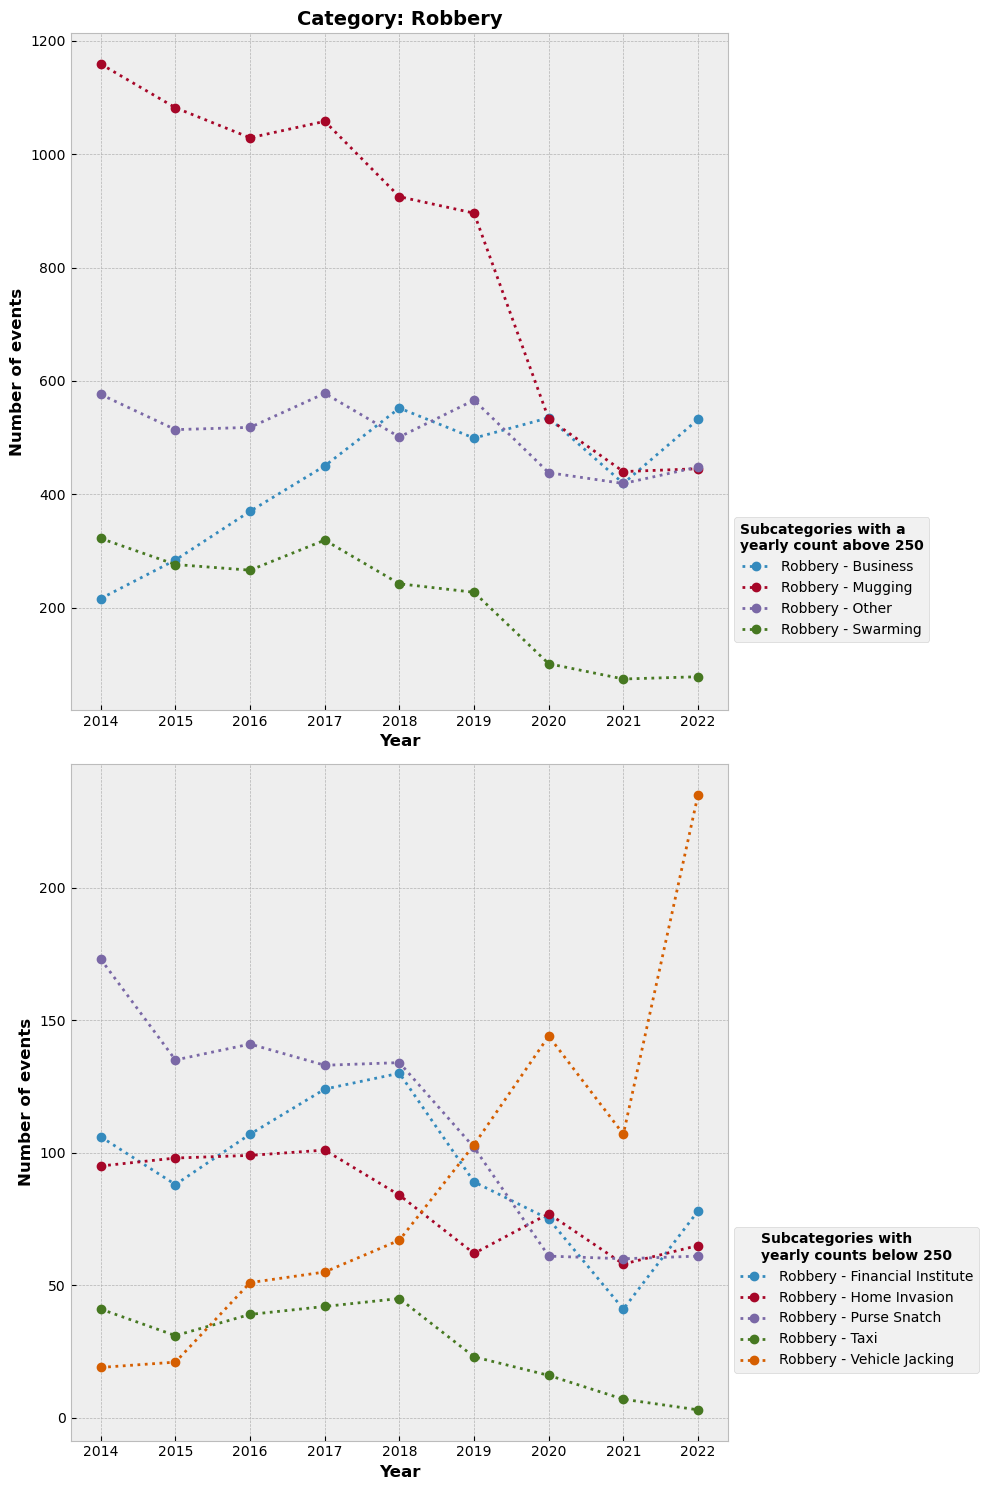

In [12]:
# Visualize
min_count = 0
mid_lim = 250
# max_count = max(year_offence_count['Number of events']) + 1
# only show moderate and
limitcorr = 0.5

cat = cats[3]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat}")
offences = list(this_data['Offence'].unique())
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 15))
for offence in offences:
    
    this_data_off = this_data.loc[this_data['Offence'] == offence]


    if any(this_data_off['Number of events'] > min_count):
        if max(this_data_off['Number of events']) < mid_lim:
            ax = ax2
        else:
            ax = ax1


        
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )

for ax in [ax1, ax2]:
    if ax is ax1:
        legend_title = 'Subcategories with a\nyearly count above ' + str(mid_lim)
    else:
        legend_title = 'Subcategories with \nyearly counts below ' + str(mid_lim)

    ax.legend(
        loc=(1.01, 0.1),
        title=legend_title,
        title_fontproperties={'weight': 700}
    )
    
    ax.set_ylabel(
        'Number of events' ,
        fontdict={'weight': 700}
    )
    
    
    ax.set_xlabel('Year', fontdict={'weight': 700})

ax1.set_title(
        'Category: ' + cat,
        fontdict={'weight': 700, 'size': 14}
    )

plt.tight_layout()

plt.show()



### Theft Over

Category: Theft Over 5000 CAD
Subcategory: Theft From Mail / Bag / Key
The Pearson's correlation for Year and Number of events is:
        	0.68	(p = 0.042)

Subcategory: Theft From Motor Vehicle Over
The Pearson's correlation for Year and Number of events is:
        	0.80	(p = 0.009)

Subcategory: Theft Over - Bicycle
The Pearson's correlation for Year and Number of events is:
        	-0.58	(p = 0.169)



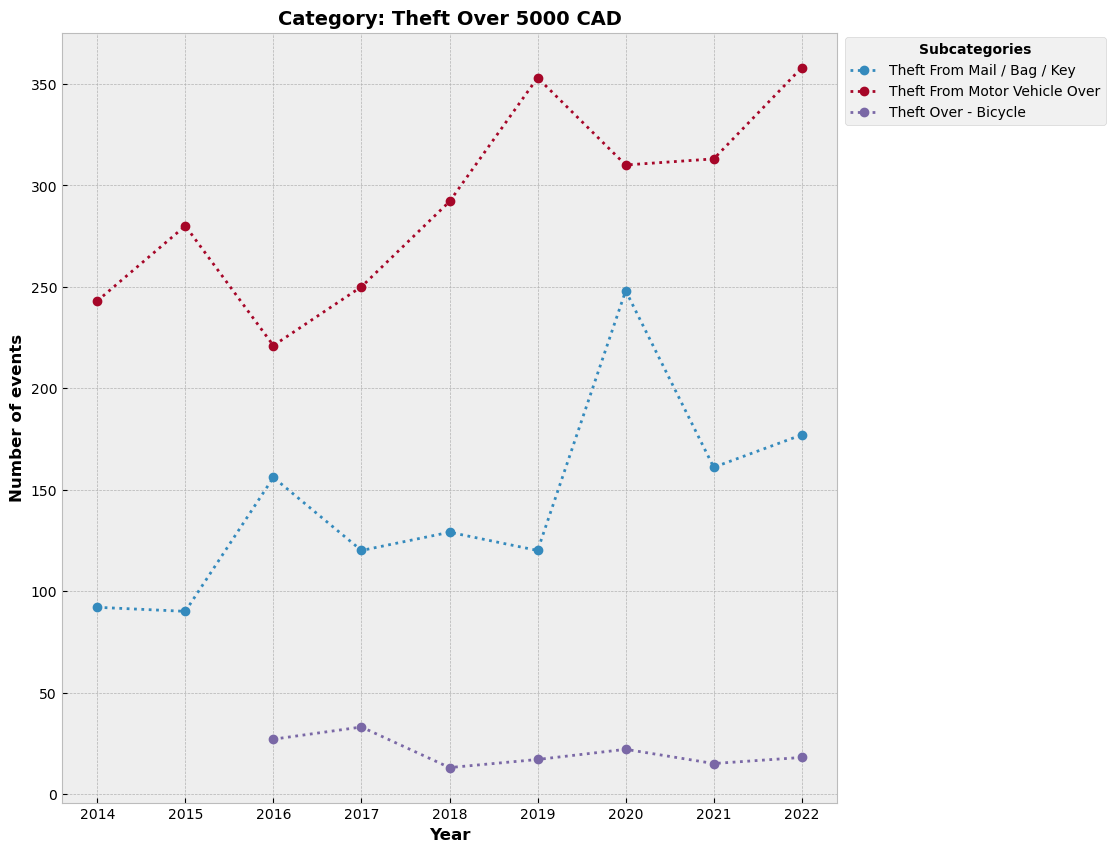

In [13]:
# Visualize

min_count = 5
# only show moderate and high correlations
limitcorr = 0.5

cat = cats[4]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat} 5000 CAD")
offences = list(this_data['Offence'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for offence in offences:

    this_data_off = this_data.loc[this_data['Offence'] == offence]

    if any(this_data_off['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )
ax.legend(loc=(1.01, 0.88), title='Subcategories', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Category: ' + cat + ' 5000 CAD',
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()



## By location type

Most interesting: Transit and Other location types

In [14]:
year_loc_df = (df
    .groupby(['Year', 'Premises Type', 'Location Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)
premises = list(year_loc_df['Premises Type'].unique())
year_loc_df

,Year,Premises Type,Location Type,Number of events
0,2014,Apartment,"Apartment (Rooming House, Condo)",7421
1,2014,Commercial,Bank And Other Financial Institutions (Money M...,191
2,2014,Commercial,Bar / Restaurant,1278
3,2014,Commercial,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",395
4,2014,Commercial,"Construction Site (Warehouse, Trailer, Shed)",193
...,...,...,...,...
437,2022,Transit,Ttc Street Car,71
438,2022,Transit,Ttc Subway Station,599
439,2022,Transit,Ttc Subway Train,175
440,2022,Transit,Ttc Subway Tunnel / Outdoor Tracks,4


### Commercial

Premises Type: Commercial
Location type: Construction Site (Warehouse, Trailer, Shed)


The Pearson's correlation for Year and Number of events is:
        	0.85	(p = 0.004)

Location type: Convenience Stores
The Pearson's correlation for Year and Number of events is:
        	0.66	(p = 0.053)

Location type: Dealership (Car, Motorcycle, Marine, Trailer, Etc.)
The Pearson's correlation for Year and Number of events is:
        	0.80	(p = 0.010)

Location type: Gas Station (Self, Full, Attached Convenience)
The Pearson's correlation for Year and Number of events is:
        	0.88	(p = 0.002)



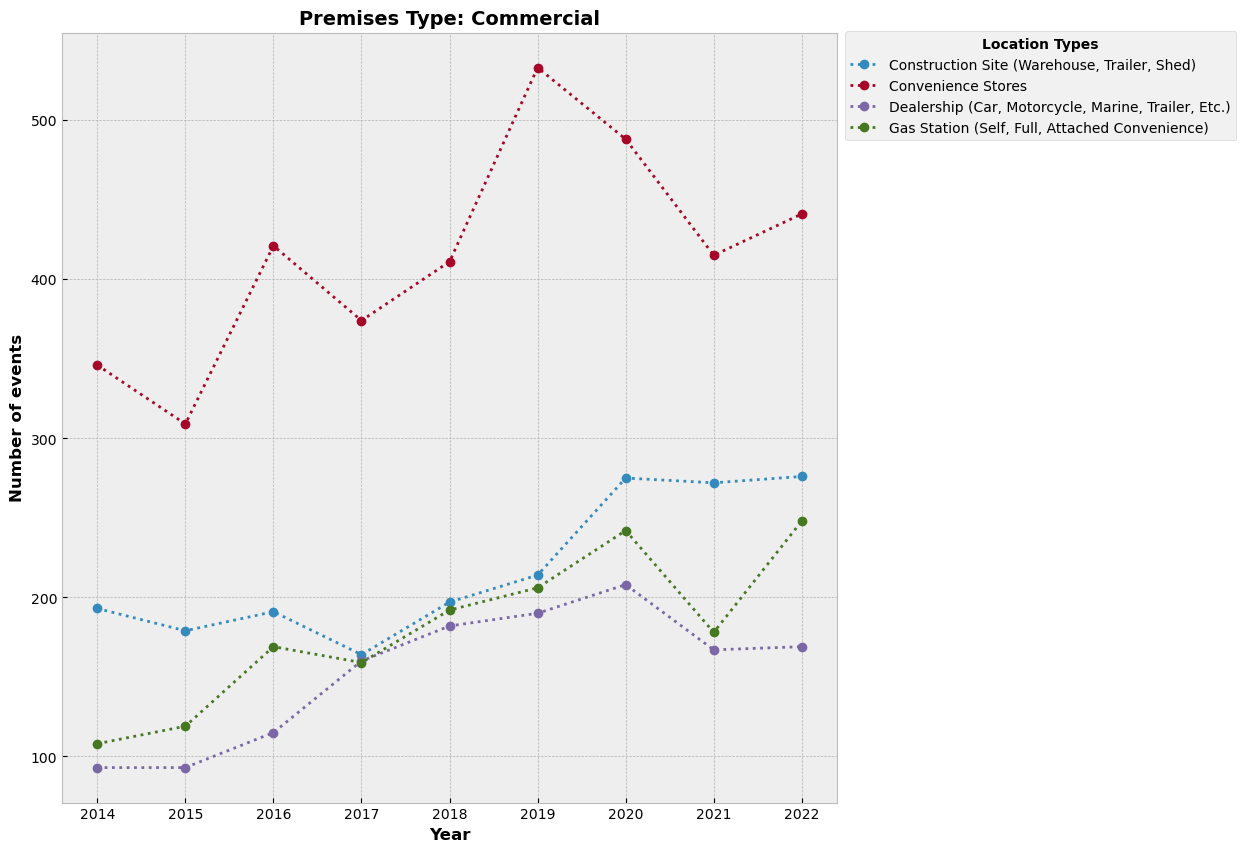

In [15]:
# Visualize
max_count = 2000
# only show moderate and
limitcorr = 0.5

prem = premises[1]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] < max_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.86), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Educational

Premises Type: Educational
Location type: Schools During Supervised Activity
The Pearson's correlation for Year and Number of events is:
        	-0.60	(p = 0.089)

Location type: Schools During Un-Supervised Activity
The Pearson's correlation for Year and Number of events is:
        	-0.72	(p = 0.030)



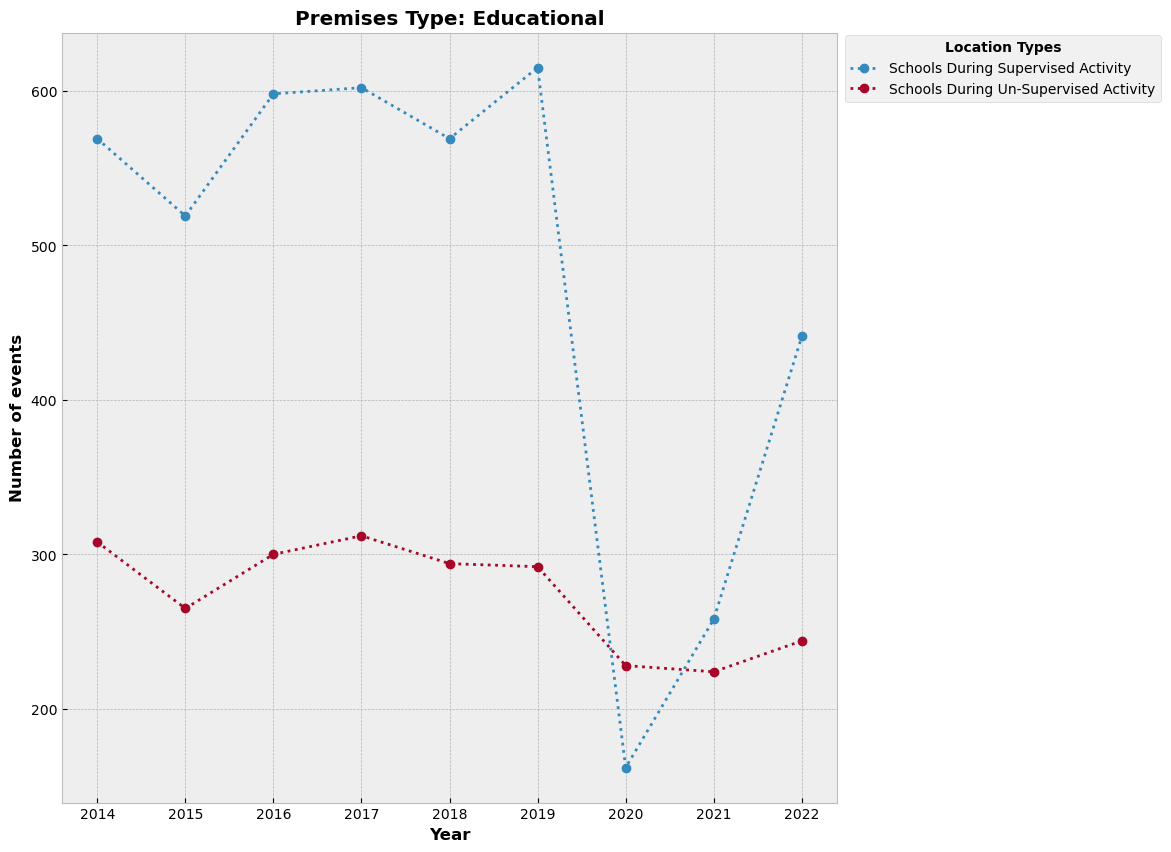

In [16]:
# Visualize
min_count = 100
# only show moderate and
limitcorr = 0.5

prem = premises[2]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.91), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Other premises type

Premises Type: Other
Location type: Group Homes (Non-Profit, Halfway House, Social Agency)
The Pearson's correlation for Year and Number of events is:
        	-0.47	(p = 0.199)

Location type: Homeless Shelter / Mission
The Pearson's correlation for Year and Number of events is:
        	0.92	(p < 0.001)

Location type: Private Property Structure (Pool, Shed, Detached Garage)
The Pearson's correlation for Year and Number of events is:
        	0.92	(p < 0.001)



Location type: Pharmacy
The Pearson's correlation for Year and Number of events is:
        	0.95	(p < 0.001)

Location type: Nursing Home
The Pearson's correlation for Year and Number of events is:
        	-0.75	(p = 0.086)



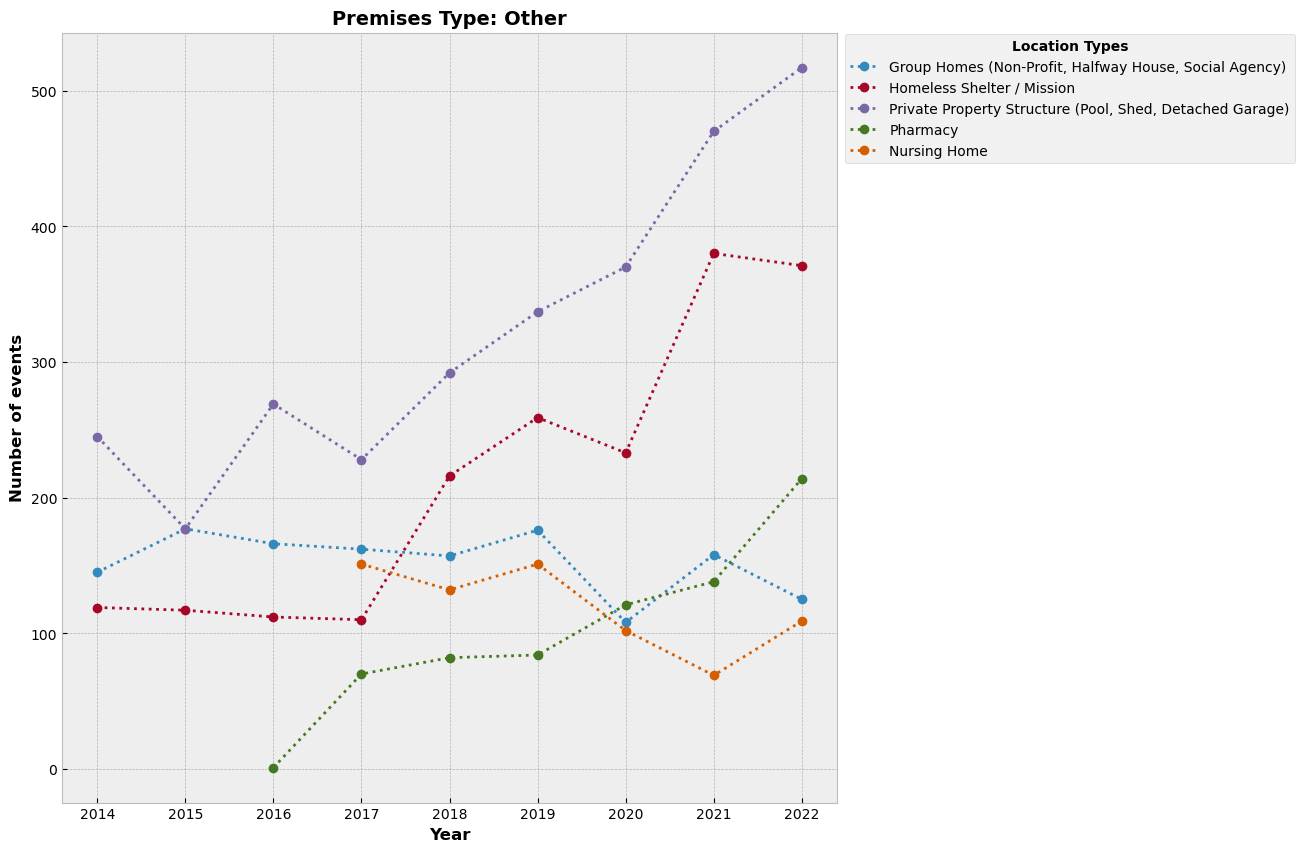

In [17]:
# Visualize
min_count = 125
# only show moderate and
limitcorr = 0.45

prem = premises[4]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.83), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Outside

Premises Type: Outside
Location type: Open Areas (Lakes, Parks, Rivers)
The Pearson's correlation for Year and Number of events is:
        	-0.59	(p = 0.093)

Location type: Parking Lots (Apt., Commercial Or Non-Commercial)
The Pearson's correlation for Year and Number of events is:
        	0.76	(p = 0.017)



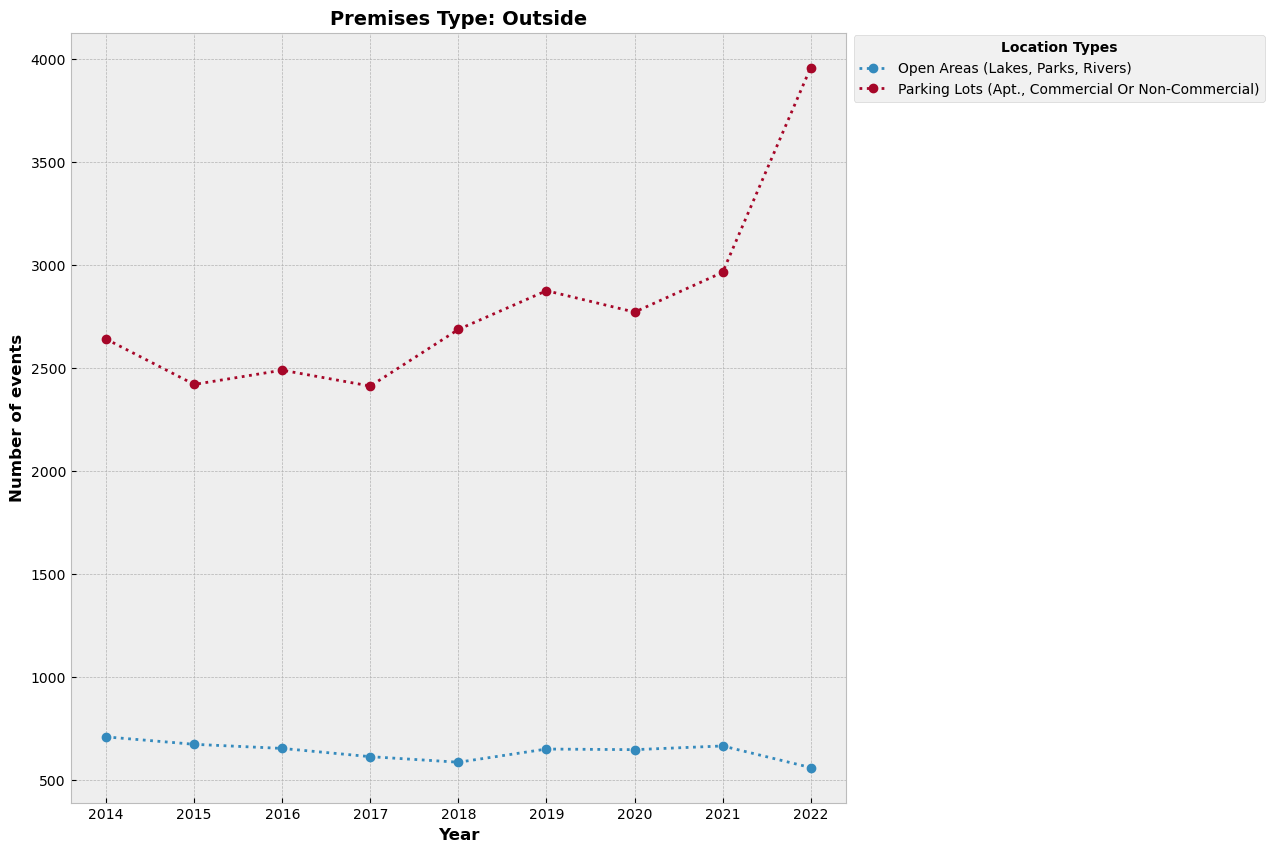

In [18]:
# Visualize
min_count = 0
# only show moderate and
limitcorr = 0.5

prem = premises[5]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df(
            'Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.91), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Transit

Premises Type: Transit
Location type: Go Station
The Pearson's correlation for Year and Number of events is:
        	0.72	(p = 0.027)

Location type: Ttc Bus
The Pearson's correlation for Year and Number of events is:
        	0.71	(p = 0.032)



Location type: Ttc Street Car
The Pearson's correlation for Year and Number of events is:
        	0.72	(p = 0.027)

Location type: Ttc Subway Station
The Pearson's correlation for Year and Number of events is:
        	0.96	(p < 0.001)

Location type: Ttc Subway Train
The Pearson's correlation for Year and Number of events is:
        	0.89	(p = 0.001)



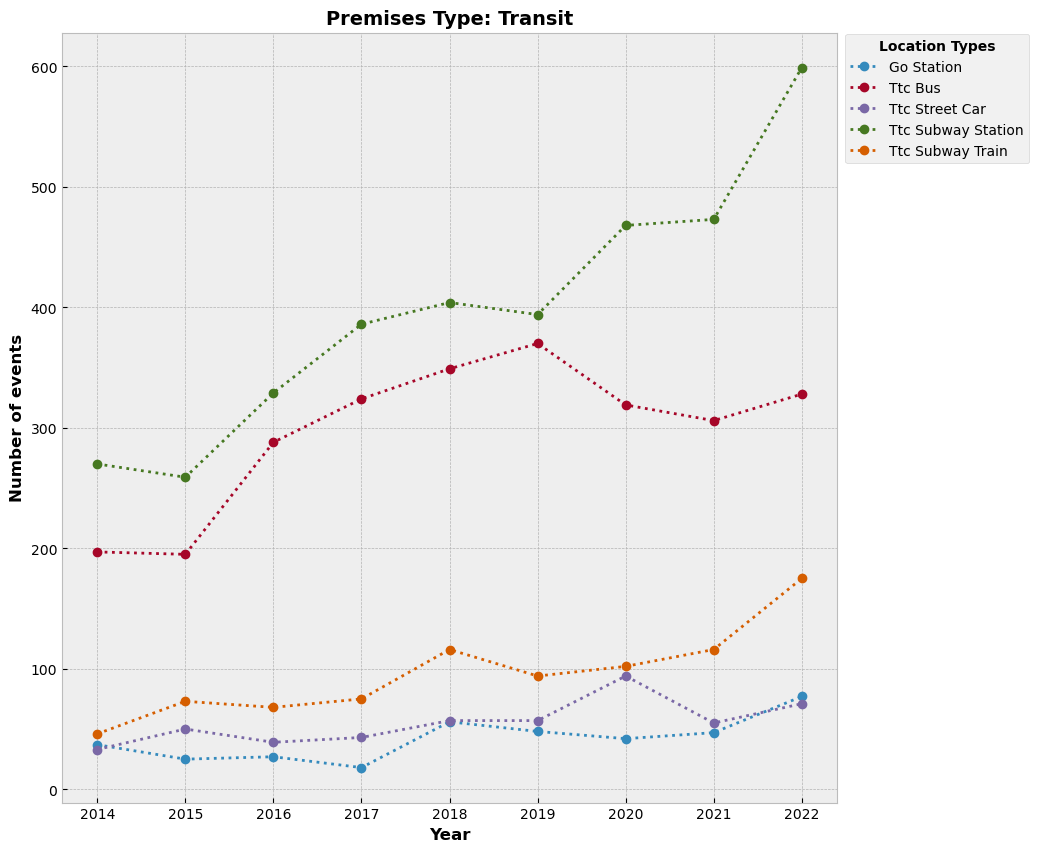

In [19]:
# Visualize
min_count = 30
# only show moderate and
limitcorr = 0.5

prem = premises[6]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.83), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()
